In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import plot_model

In [2]:
# Load your Numpy arrays
comments_train = pd.read_csv('./tc_train.csv')
comments_test = pd.read_csv('./tc_test.csv')

In [3]:
comments_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [4]:
comments_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index
embeddings_path = "./crawl-300d-2M.vec"
embeddings_index = get_embeddings(embeddings_path)

In [6]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

In [7]:
### PROCESS TRAINING DATA

from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

comments_train['description'] = comments_train.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(comments_train.description)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')


### APPLY TO TEST DATA
comments_test['description'] = comments_test.comment_text.apply(preprocess)

Creating the vocabulary of words occurred more than 5
45259 top words


In [8]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['jennifer', 'faceted', 'les', 'stubborness', 'collude', 'checklist', 'checkusers', 'amongst', 'lies', 'indexes']

Is "unknown" in top_words? 
 True


In [9]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

In [10]:
comments_train['description'] = comments_train.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

comments_test['description'] = comments_test.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

In [11]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(comments_train.description)
print(tokenizer)

In [12]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

40185


[('unknown', 1),
 ('the', 2),
 ('to', 3),
 ('of', 4),
 ('and', 5),
 ('a', 6),
 ('you', 7),
 ('i', 8),
 ('is', 9),
 ('that', 10),
 ('in', 11),
 ('it', 12),
 ('for', 13),
 ('this', 14),
 ('not', 15),
 ('on', 16)]

In [13]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(comments_train.description)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open('./text_train_data.pkl','wb') as f: pickle.dump(data, f, -1)

seq_test = tokenizer.texts_to_sequences(comments_test.description)
data_test = pad_sequences(seq_test,maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
with open('./text_test_data.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[668, 77, 2, 133, 130, 176, 31, 658, 4322, 10972, 1109, 85, 347, 1, 52, 1, 12090, 1, 51, 6172, 16, 60, 2522, 147, 8, 2744, 34, 116, 1179, 15205, 2412, 1, 5, 48, 61, 245, 2, 357, 32, 2, 42, 28, 142, 1, 3422, 89, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 53, 2714, 14, 463, 3572, 1, 4414, 2647, 22, 1, 93, 1, 1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1, 953, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195, 1]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  668    77     2   133   130   176    31   658  4322 10972  1109    85
   347     1    52     1 12090     1    51  6172    16    60  2522   147
     8  2744    34   116  1179 15205  2412     1     5    48    61   245
     2   357    32     2    42    28   142     1  3422    89     1     1
     1     1]


In [14]:
mlist=['word_1','word_2','word_3']
moveIter=iter(mlist)
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))

word_1
word_2
word_3
enough
enough


In [15]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

In [16]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

In [17]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = './text_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

0 unknown words


In [18]:
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate

def get_more_complex_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    
    # Stack multiple LSTM layers
    x = LSTM(50, return_sequences=True)(x)
    x = LSTM(50, return_sequences=True)(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    x = BatchNormalization()(conc)
    x = Dropout(0.5)(x)  # Increased dropout rate
    
    # Multiple dense layers
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    output_layer = Dense(6, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer='RMSProp')  # Changed optimizer
    return model


In [19]:
# def get_model():
#     input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
#     x = embedding_layer(input_layer)
#     x = SpatialDropout1D(0.5)(x)
#     x = LSTM(10, return_sequences=True)(x)
#     x = Conv1D(5, kernel_size=2, padding="valid")(x)
#     x = Flatten()(x)
#     x = BatchNormalization()(x)
#     x = Dropout(.2)(x)
#     output_layer = Dense(1, activation="sigmoid")(x)
#     model = Model(inputs=input_layer, outputs=output_layer)
#     model.compile(loss="binary_crossentropy", optimizer=Adam())
#     return model

In [20]:
data.shape

(223549, 50)

In [21]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels_array = comments_train[label_columns].values

In [22]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: 
    embedding_layer = pickle.load(f)

with open('./text_train_data.pkl', 'rb') as f: 
    data = pickle.load(f)

# Removed stratify parameter for a random split
X_train, X_test, y_train, y_test = train_test_split(data, labels_array, test_size=0.2, random_state=0)

In [51]:
best_model_path = 'best_model_WOW.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=10)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_more_complex_model()
print(model.summary())
plot_model(model, to_file='comment_reviews.png',show_shapes=True,show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      12055800    ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 50, 300)     0           ['embedding[2][0]']              
 opout1D)                                                                                         
                                                                                                  
 lstm_4 (LSTM)                  (None, 50, 50)       70200       ['spatial_dropout1d_2[0][0]

In [52]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=3, batch_size=BATCH_SIZE, shuffle=True, verbose=1,
                 callbacks=[model_checkpoint])
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC', roc_auc_score(y_test, test_pred))

Epoch 1/3


350/350 [==============================] - 14s 32ms/step - loss: 0.1088 - val_loss: 0.0815
Epoch 2/3
350/350 [==============================] - 11s 30ms/step - loss: 0.0700 - val_loss: 0.0635
Epoch 3/3
350/350 [==============================] - 11s 30ms/step - loss: 0.0656 - val_loss: 0.0584
validation AUC 0.9680424572116341


In [53]:
# Make predictions on the validation set
val_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('Validation AUC:', roc_auc_score(y_test, val_pred))

# Make predictions on the test dataset
test_pred = model.predict(data_test, batch_size=BATCH_SIZE, verbose=0)

Validation AUC: 0.9680424572116341


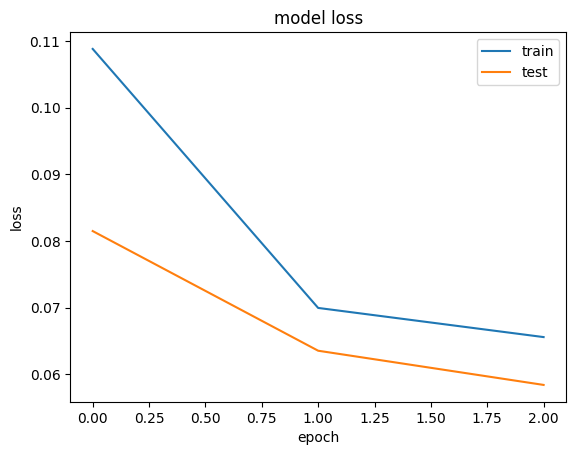

In [54]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

### Get submission predictions

In [55]:
comments_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,description
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,unknown unknown he matches this background col...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man unknown unknown really not trying to e...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,unknown unknown more i can't make any real sug...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you unknown sir unknown are my hero unknown an...


In [56]:
data_test

array([[2223,  470, 5992, ...,   11, 1546,  639],
       [   1,    1,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       ...,
       [   1,    1,    1, ...,    1,    1,  203],
       [   1,    1,    1, ...,    1, 1405, 2415],
       [   1,    1,    1, ...,    0,    0,    0]])

In [57]:
comments_test['id']

0        00001cee341fdb12
1        0000247867823ef7
2        00013b17ad220c46
3        00017563c3f7919a
4        00017695ad8997eb
               ...       
89181    fffcd0960ee309b5
89182    fffd7a9a6eb32c16
89183    fffda9e8d6fafa9e
89184    fffe8f1340a79fc2
89185    ffffce3fb183ee80
Name: id, Length: 89186, dtype: object

In [58]:
# Create a DataFrame from the numpy array
df = pd.DataFrame(test_pred, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

# Add an 'id' column
df['id'] = comments_test['id']

# Save the DataFrame to a CSV file with the correct headers
df[['id'] + ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_csv('submission.csv', index=False)
